In [8]:

import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from pathlib import Path
import argparse
import logging


# --- Configuration ---
CONFIG_FILE = Path('config_pair_session_bitget.json')

def load_config():
    """Load configuration file."""
    if not CONFIG_FILE.exists():
        raise FileNotFoundError(f"Config file not found at {CONFIG_FILE}")
    with open(CONFIG_FILE, 'r') as f:
        return json.load(f)

config = load_config()
OUTPUT_DIR = Path(config.get('output_directory', 'output_bitget'))

def get_active_strategies():
    """Return list of active strategy names."""
    active_strategies = [
        strat_name for strat_name, strat_config in config.get('strategy', {}).items()
        if strat_config.get('active', False)
    ]
    print(f"Active strategies: {active_strategies}")
    return active_strategies

def plot_metrics(selection: str, show_strategies: bool = False):
    """
    Plot portfolio metrics over time for a strategy or account.
    For strategies (active only):
      - portfolio_return_pct, portfolio_realized_pnl, portfolio_unrealized_pnl
    For accounts:
      - portfolio_return_pct, portfolio_total_pnl, portfolio_realized_pnl, portfolio_unrealized_pnl
      - Optionally overlay active strategy-level realized and unrealized PnL
    """
    # Get active strategies
    active_strategies = get_active_strategies()
    accounts = list(config.get('allocations', {}).get('bitget', {}).keys())
    is_strategy = selection in active_strategies
    is_account = selection in accounts
    
    # Validate selection
    if not (is_strategy or is_account):
        if selection in config.get('strategy', {}):
            print(f"'{selection}' is an inactive strategy. Active strategies: {active_strategies}")
        else:
            print(f"'{selection}' is neither a valid active strategy nor an account.")
        return
    
    # Helper to load timeline data
    def load_timeline(entity: str, is_acc: bool = False) -> dict:
        path = OUTPUT_DIR / (f"pnl_timeline_account_{entity}.json" if is_acc else f"pnl_timeline_{entity}.json")
        if not path.exists():
            print(f"{path} not found")
            return {}
        try:
            with open(path, 'r') as f:
                return json.load(f)
        except Exception as e:
            print(f"Failed to load {path}: {e}")
            return {}
    
    # Collect data
    timeline_data = {}
    timestamps = set()
    
    if is_strategy:
        timeline_data[selection] = load_timeline(selection, False)
        timestamps.update(timeline_data[selection].keys())
    else:
        timeline_data[selection] = load_timeline(selection, True)
        timestamps.update(timeline_data[selection].keys())
        if show_strategies:
            # Load active strategies for this account
            account_strategies = config.get('allocations', {}).get('bitget', {}).get(selection, {}).get('strategies', active_strategies)
            account_strategies = [s for s in account_strategies if s in active_strategies]
            print(f"Overlaying active strategies for account {selection}: {account_strategies}")
            for strat in account_strategies:
                timeline_data[strat] = load_timeline(strat, False)
                timestamps.update(timeline_data[strat].keys())
    
    if not timestamps:
        print(f"No data available for {selection}")
        return
    
    # Prepare timestamps
    sorted_ts = sorted(timestamps, key=lambda s: datetime.strptime(s, '%Y/%m/%d %H:%M:%S.%f'))
    ts_dt = [datetime.strptime(ts, '%Y/%m/%d %H:%M:%S.%f') for ts in sorted_ts]
    
    # Create subplots
    n_plots = 3 if is_strategy else 4
    fig, axs = plt.subplots(n_plots, 1, figsize=(12, 4 * n_plots), sharex=True)
    axs = [axs] if n_plots == 1 else axs  # Handle single subplot case
    
    # Plot metrics
    plot_idx = 0
    
    # 1) Portfolio Return %
    for label, series in timeline_data.items():
        vals = [series.get(ts, {}).get('portfolio_return_pct', None) for ts in sorted_ts]
        vals = [v * 100 if v is not None else None for v in vals]  # Convert to percentage
        linestyle = '-' if label == selection or not show_strategies else '--'
        label_suffix = ' (Account)' if is_account and label == selection and show_strategies else ' (Strategy)' if is_account and label != selection else ''
        axs[plot_idx].plot(ts_dt, vals, linestyle=linestyle, label=f"{label}{label_suffix}")
    axs[plot_idx].set_title('Portfolio Return')
    axs[plot_idx].set_ylabel('Return (%)')
    axs[plot_idx].grid(True)
    axs[plot_idx].legend()
    plot_idx += 1
    
    # 2) Portfolio Total PnL (Account only)
    if is_account:
        for label, series in timeline_data.items():
            if label != selection:
                continue
            vals = []
            for ts in sorted_ts:
                data = series.get(ts, {})
                realized = data.get('portfolio_realized_pnl', 0) or 0
                unrealized = data.get('portfolio_unrealized_pnl', 0) or 0
                total_pnl = realized + unrealized
                vals.append(total_pnl)
            axs[plot_idx].plot(ts_dt, vals, label=f"{label} (Account)")
        axs[plot_idx].set_title('Portfolio Total PnL')
        axs[plot_idx].set_ylabel('PnL (USD)')
        axs[plot_idx].grid(True)
        axs[plot_idx].legend()
        plot_idx += 1
    
    # 3) Portfolio Realized PnL
    for label, series in timeline_data.items():
        if is_account and label != selection and not show_strategies:
            continue
        vals = [series.get(ts, {}).get('portfolio_realized_pnl', None) for ts in sorted_ts]
        linestyle = '-' if label == selection or is_strategy else '--'
        label_suffix = ' (Strategy)' if is_account and label != selection else ''
        axs[plot_idx].plot(ts_dt, vals, linestyle=linestyle, label=f"{label}{label_suffix}")
    axs[plot_idx].set_title('Portfolio Realized PnL')
    axs[plot_idx].set_ylabel('PnL (USD)')
    axs[plot_idx].grid(True)
    axs[plot_idx].legend()
    plot_idx += 1
    
    # 4) Portfolio Unrealized PnL
    for label, series in timeline_data.items():
        if is_account and label != selection and not show_strategies:
            continue
        vals = [series.get(ts, {}).get('portfolio_unrealized_pnl', None) for ts in sorted_ts]
        linestyle = '-' if label == selection or is_strategy else '--'
        label_suffix = ' (Strategy)' if is_account and label != selection else ''
        axs[plot_idx].plot(ts_dt, vals, linestyle=linestyle, label=f"{label}{label_suffix}")
    axs[plot_idx].set_title('Portfolio Unrealized PnL')
    axs[plot_idx].set_ylabel('PnL (USD)')
    axs[plot_idx].grid(True)
    axs[plot_idx].legend()
    
    # X-axis formatting
    axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    plt.xticks(rotation=45)
    plt.xlabel('Timestamp')
    plt.tight_layout()
    
    plt.show()


Active strategies: ['basket1', 'basket1b', 'basket2', 'basket2b']


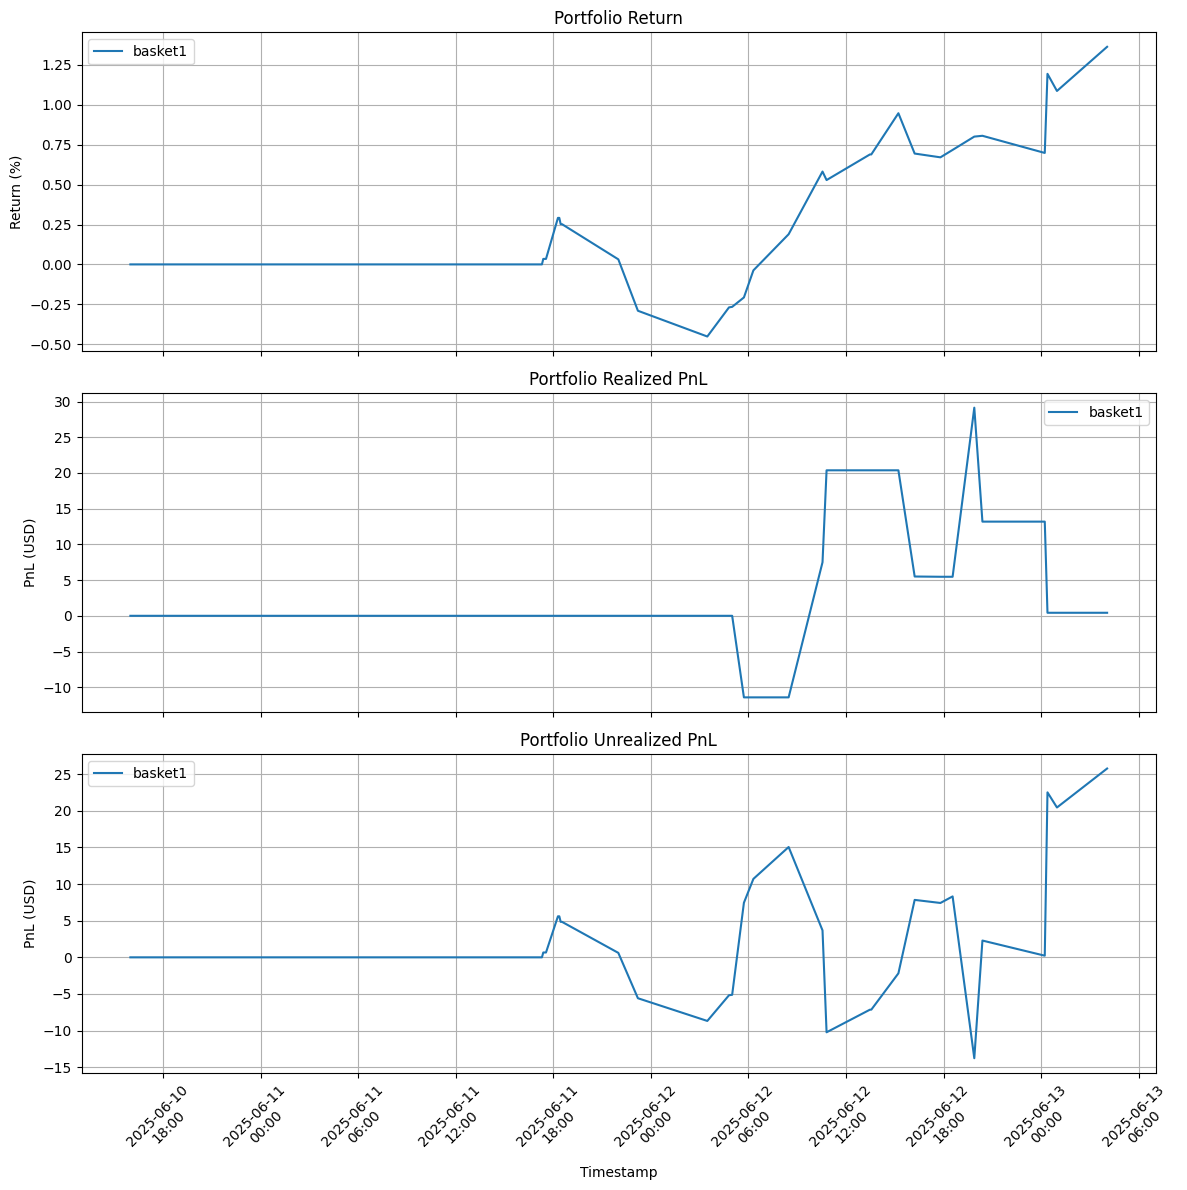

In [17]:
# Example usage
plot_metrics('basket1')



Active strategies: ['basket1', 'basket1b', 'basket2', 'basket2b']
Overlaying active strategies for account 2: ['basket1', 'basket1b', 'basket2', 'basket2b']


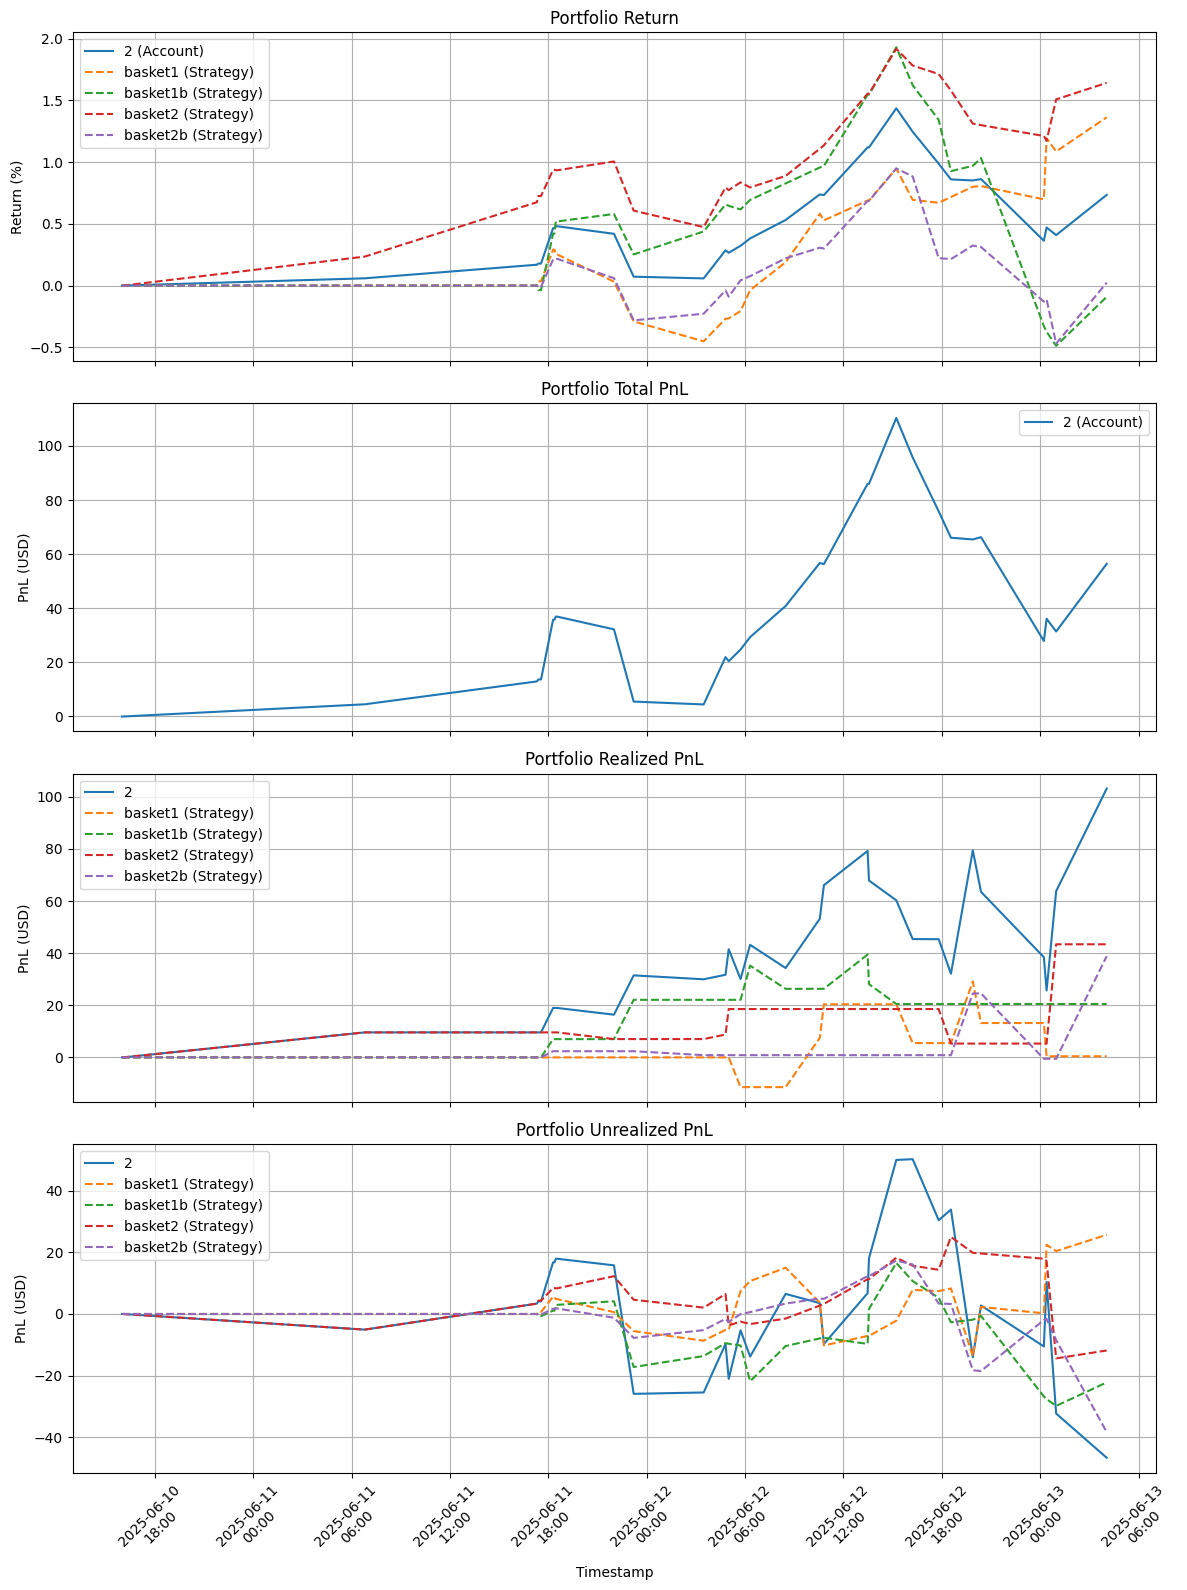

In [18]:
plot_metrics('2', show_strategies=True)  # Example for account with strategies